### find maxima of variance

note: https://developpaper.com/a-pit-of-mkl-library-in-linux-anaconda/ was helpful

https://github.com/cornellius-gp/gpytorch/issues/772

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import torch
from botorch.utils import standardize

In [4]:
data = torch.from_numpy(np.load('west_coast.npy'))

In [5]:
data = standardize(data).numpy()

In [6]:
X = np.empty((np.prod(data.shape),2))

In [7]:
for i in range(data.shape[1]): X[i::data.shape[1], 0] = np.arange(data.shape[0])
for i in range(data.shape[0]): X[i*data.shape[1]:(i+1)*data.shape[1], 1] = np.arange(data.shape[1])

In [8]:
coords = X

In [9]:
coords

array([[  0.,   0.],
       [  0.,   1.],
       [  0.,   2.],
       ...,
       [199., 197.],
       [199., 198.],
       [199., 199.]])

In [10]:
coords /= .5*np.max(coords, 0)
coords -= 1

In [11]:
coords

array([[-1.        , -1.        ],
       [-1.        , -0.98994975],
       [-1.        , -0.9798995 ],
       ...,
       [ 1.        ,  0.9798995 ],
       [ 1.        ,  0.98994975],
       [ 1.        ,  1.        ]])

In [12]:
# coords, data = coords[::5], data[::5,::5]

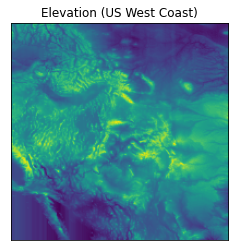

In [91]:
plt.imshow(data.reshape(200,200))
plt.xticks([])
plt.title('Elevation (US West Coast)')
plt.yticks([]);
plt.savefig('geo_west_high_res')

In [15]:
data = data.flatten()

In [16]:
coords.shape, data.shape

((40000, 2), (40000,))

In [17]:
select = np.random.choice(np.arange(len(data)), 1000)

In [18]:
gpr = GaussianProcessRegressor(kernel=1.**2 * RBF(1.0) + WhiteKernel()).fit(coords[select], data[select])

In [47]:
posterior = gpr.predict(coords)

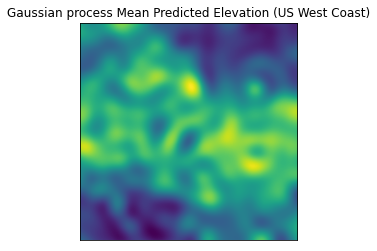

In [20]:
plt.imshow(posterior.reshape(200,200))
plt.xticks([])
plt.title('Gaussian process Mean Predicted Elevation (US West Coast)')
plt.yticks([]);
plt.savefig('mean')

In [21]:
import functools

In [22]:
def func(x, gp):
    return -gp.predict(x.reshape(1,-1))[0]

In [23]:
from scipy.optimize import minimize

In [24]:
from numdifftools import Jacobian, Hessian

In [25]:
def fun_der(x, a):
    return Jacobian(lambda x: func(x, a))(x).ravel()

In [26]:
fun_der(np.ones(2), gpr)

array([ 3.47086484, -5.5222598 ])

In [27]:
from dask.distributed import Client

In [28]:
from hgdl import hgdl

In [36]:
client = Client(processes=False)

In [37]:
client

Client Scheduler: inproc://192.168.43.208/22083/10 Dashboard: http://192.168.43.208:8787/status,Cluster Workers: 1 Cores: 12 Memory: 16.57 GB


In [38]:
res = hgdl.HGDL(func=functools.partial(func, gp=gpr), grad=functools.partial(fun_der,a=gpr), bounds=np.array([[-1,1],[-1,1.]]), client=client, bestX=-1, num_epochs=10, num_individuals=40)

In [39]:
res = res.get_final()

In [40]:
save1 = res

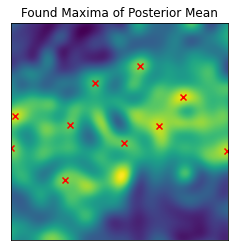

In [49]:
plt.imshow(posterior.reshape(200,200))
for x in res['minima_x']: plt.scatter((x[1]+1)*100, (x[0]+1)*100, marker='x', color='red')
plt.xlim(0,200)
plt.ylim(0,200)
plt.xticks([])
plt.yticks([])
plt.savefig('hgdl_mean_maxima')
plt.title('Found Maxima of Posterior Mean');

In [42]:
from gc import collect

In [50]:
collect()

7666

In [51]:
posterior = gpr.predict(coords, return_std=True)[1]

In [54]:
posterior.shape

(40000,)

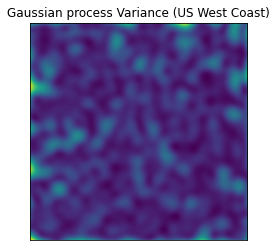

In [81]:
plt.imshow(np.sqrt(posterior).reshape(200,200))
plt.xticks([])
plt.title('Gaussian process Variance (US West Coast)')
plt.yticks([]);
plt.savefig('geo_std')

In [82]:
collect()

285638

In [83]:
client = Client(processes=False)

/home/elliott/anaconda3/envs/hgdlEnv/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34407 instead
  http_address["port"], self.http_server.port


In [84]:
client

Client Scheduler: inproc://192.168.43.208/22083/70 Dashboard: http://192.168.43.208:34407/status,Cluster Workers: 1 Cores: 12 Memory: 16.57 GB


In [85]:
def func(x, gp):
    return -np.sqrt(gp.predict(x.reshape(1,-1), return_std=True)[1][0])

In [86]:
def fun_der(x, a):
    return Jacobian(lambda x: func(x, a))(x).ravel()

In [87]:
res = hgdl.HGDL(func=functools.partial(func, gp=gpr), grad=functools.partial(fun_der,a=gpr), bounds=np.array([[-1,1],[-1,1.]]), client=client, num_epochs=10, num_individuals=20, bestX=-1)

In [88]:
res = res.get_final()

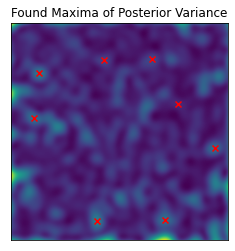

In [89]:
plt.imshow(posterior.reshape(200,200))
for x in res['minima_x']: plt.scatter((x[1]+1)*100, (x[0]+1)*100, marker='x', color='red')
plt.xlim(0,200)
plt.ylim(0,200)
plt.xticks([])
plt.yticks([])
plt.savefig('hgdl_variance_maxima')
plt.title('Found Maxima of Posterior Variance');